<a href="https://colab.research.google.com/github/larasauser/master/blob/main/visu_metrics_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install rasterio tqdm scikit-image scikit-learn piq --quiet

import os
from glob import glob
from datetime import datetime, timedelta
from tqdm import tqdm
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from scipy.linalg import lstsq
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import os
from tqdm import tqdm

# === Dossiers ===
hole_dir = '/content/drive/MyDrive/QS_herens/NDVI_herens_holes'
gt_dir = '/content/drive/MyDrive/QS_herens/NDVI_herens_full'
recon_dir = '/content/drive/MyDrive/QS_herens/QS_h_out'

# === Fonction de recadrage ===
def align_to_reference(src_path, ref_profile):
    with rasterio.open(src_path) as src:
        data = src.read(1)

        # Matrice de sortie alignée
        out = np.zeros((ref_profile['height'], ref_profile['width']), dtype=np.float32)

        reproject(
            source=data,
            destination=out,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref_profile['transform'],
            dst_crs=ref_profile['crs'],
            resampling=Resampling.nearest
        )

    return out

# === Liste des fichiers (triée pour correspondance) ===
recon_files = sorted([f for f in os.listdir(recon_dir) if f.endswith('.tif')])
gt_files    = sorted([f for f in os.listdir(gt_dir) if f.endswith('.tif')])
hole_files  = sorted([f for f in os.listdir(hole_dir) if f.endswith('.tif')])

# === Boucle principale ===
aligned_holes = []
aligned_gt    = []
aligned_recon = []

for rec_file, gt_file, hole_file in tqdm(zip(recon_files, gt_files, hole_files),
                                         total=len(recon_files),
                                         desc="Alignment"):

    rec_path  = os.path.join(recon_dir, rec_file)
    gt_path   = os.path.join(gt_dir, gt_file)
    hole_path = os.path.join(hole_dir, hole_file)

    # Ouvrir l'image de référence (QS_g_out)
    with rasterio.open(rec_path) as ref:
        ref_profile = ref.profile.copy()
        ref_img = ref.read(1)

    # Recadrer selon QS_g_out
    gt_aligned   = align_to_reference(gt_path, ref_profile)
    hole_aligned = align_to_reference(hole_path, ref_profile)

    # Sauvegarder les 3 matrices pour stats
    aligned_recon.append(ref_img)
    aligned_gt.append(gt_aligned)
    aligned_holes.append(hole_aligned)

print("✔️ Alignement terminé pour toutes les images.")


Alignment: 100%|██████████| 6/6 [00:16<00:00,  2.79s/it]

✔️ Alignement terminé pour toutes les images.


In [4]:
from pyproj import Transformer, CRS
import numpy as np

def format_coord_deg(val):
    """Formate les coordonnées en degrés avec 3 décimales pour l'espace"""
    return f'{val:.3f}°'

def add_coords_wgs84(ax, meta, show_y=True):
    """
    Ajoute automatiquement les coordonnées le long des axes en WGS84 (EPSG:4326).
    - show_y : True pour afficher les coordonnées Y (latitude), False sinon
    """
    transform = meta['transform']
    nrows, ncols = meta['height'], meta['width']

    # Indices pour les ticks
    x_idx = np.linspace(0, ncols-1, 5, dtype=int)
    y_idx = np.linspace(0, nrows-1, 5, dtype=int)
    x_pix = transform[2] + x_idx * transform[0]
    y_pix = transform[5] + y_idx * transform[4]

    # Transforme en WGS84 si nécessaire
    raster_crs = CRS(meta['crs'])
    if raster_crs.to_epsg() != 4326:
        transformer = Transformer.from_crs(raster_crs, "EPSG:4326", always_xy=True)
        x_pix, y_pix = transformer.transform(x_pix, y_pix)

    # Applique les ticks X (longitude)
    ax.set_xticks(x_idx)
    ax.set_xticklabels([format_coord_deg(x) for x in x_pix], rotation=0)

    # Applique les ticks Y (latitude) seulement si demandé
    if show_y:
        ax.set_yticks(y_idx)
        ax.set_yticklabels([format_coord_deg(y) for y in y_pix])
    else:
        ax.set_yticks([])

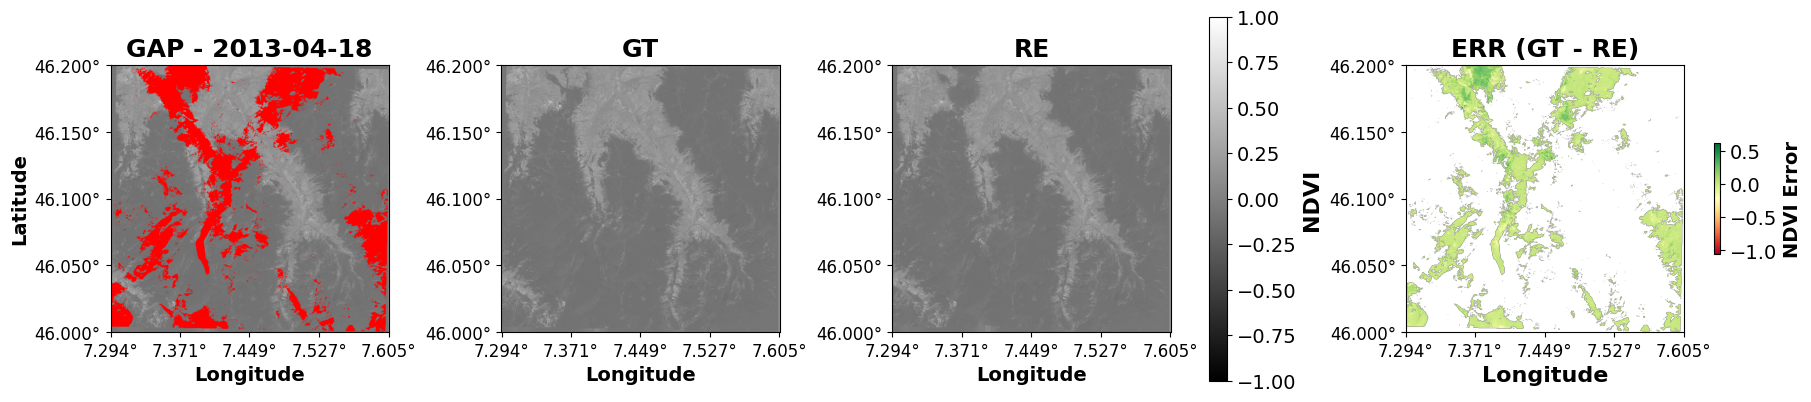

✅ Figure enregistrée : /content/drive/MyDrive/QS_herens/graph_herens_30105/qs_herens_2013-04-18.png


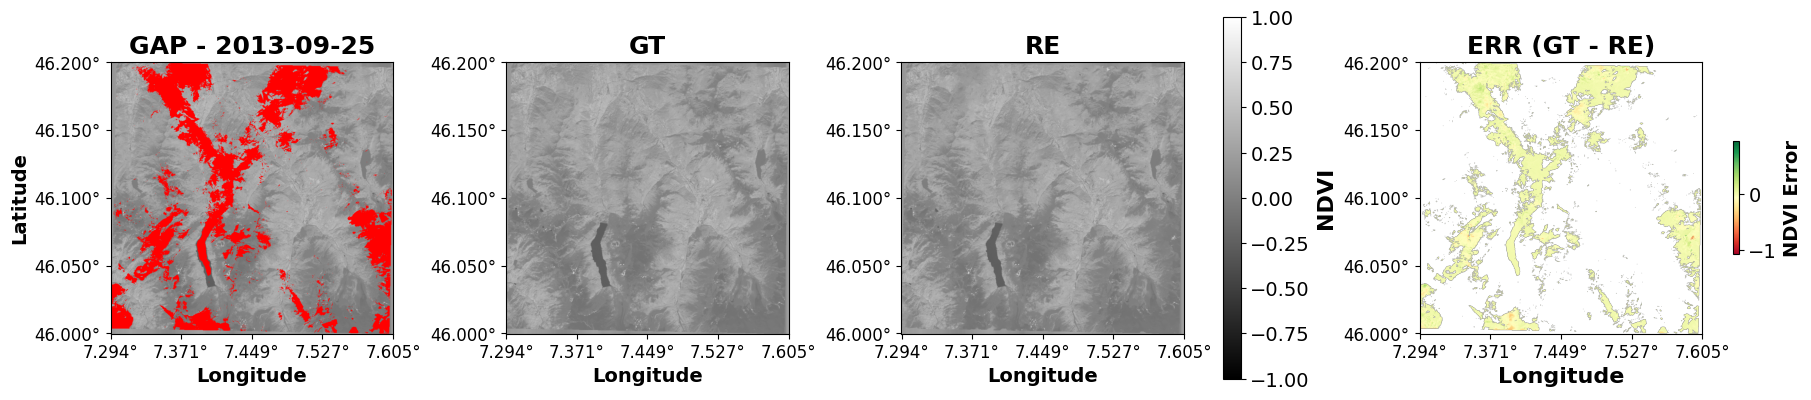

✅ Figure enregistrée : /content/drive/MyDrive/QS_herens/graph_herens_30105/qs_herens_2013-09-25.png


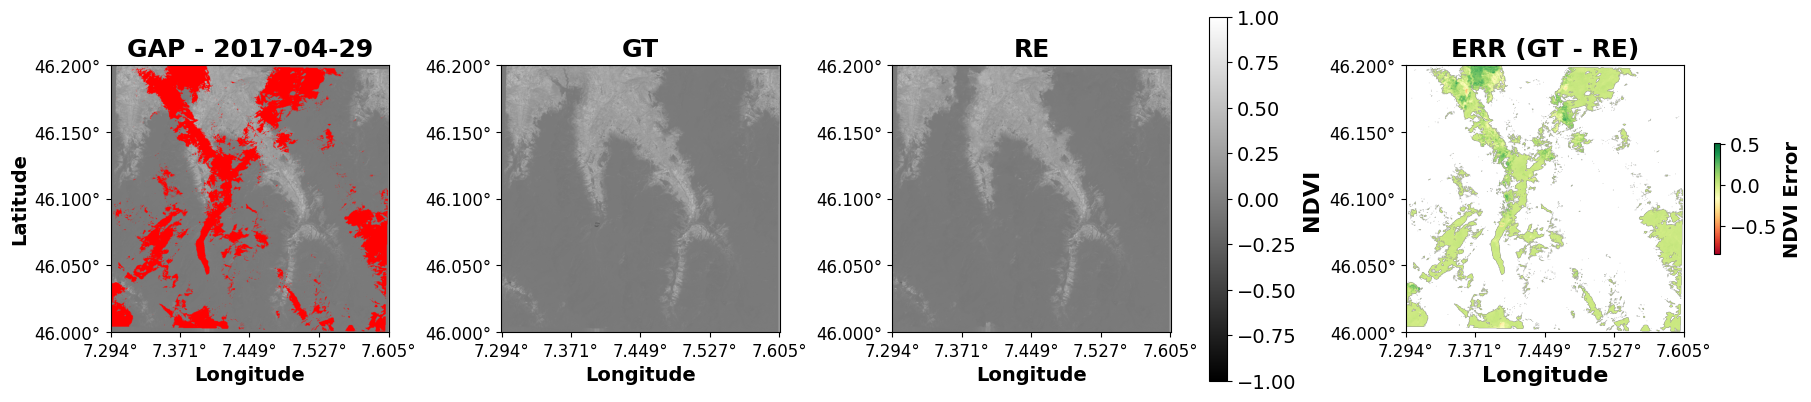

✅ Figure enregistrée : /content/drive/MyDrive/QS_herens/graph_herens_30105/qs_herens_2017-04-29.png


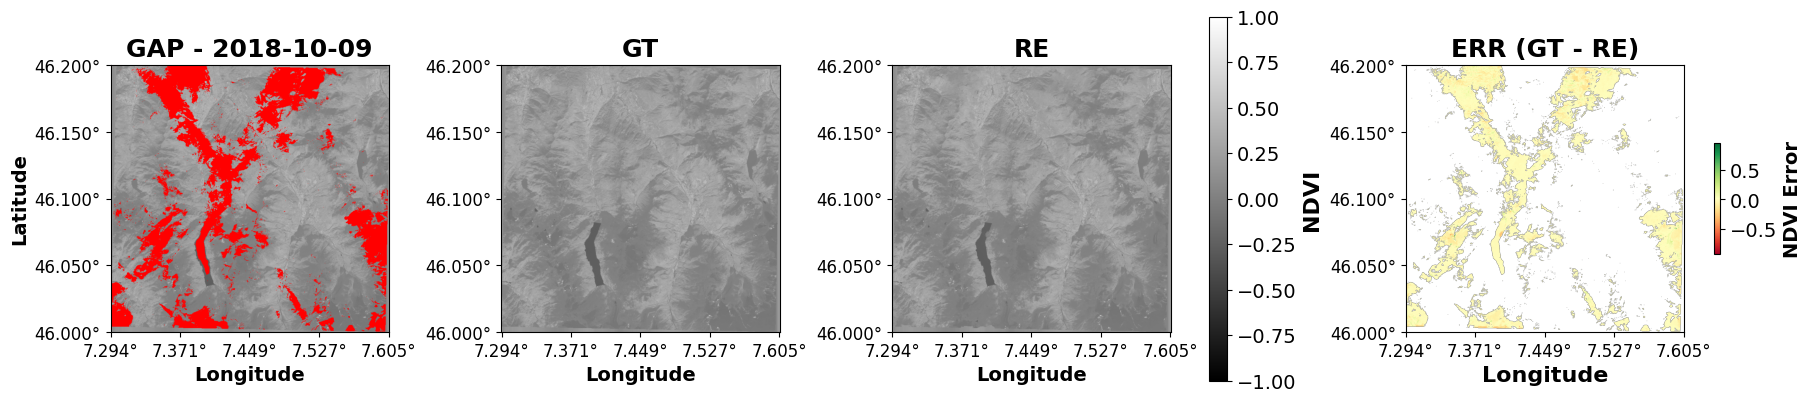

✅ Figure enregistrée : /content/drive/MyDrive/QS_herens/graph_herens_30105/qs_herens_2018-10-09.png


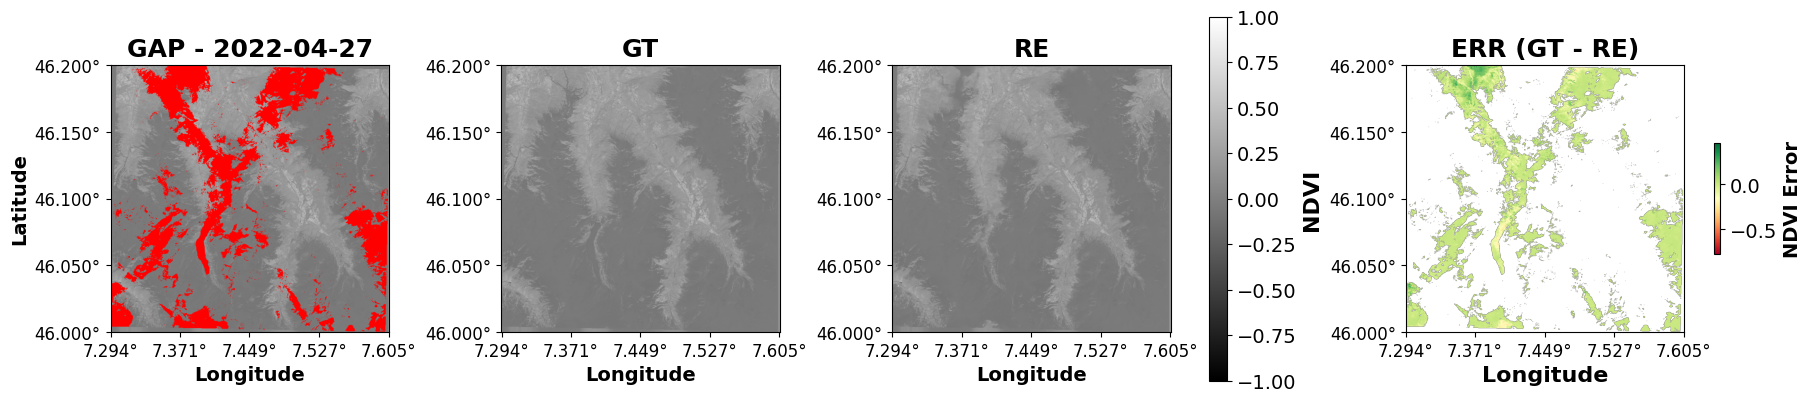

✅ Figure enregistrée : /content/drive/MyDrive/QS_herens/graph_herens_30105/qs_herens_2022-04-27.png


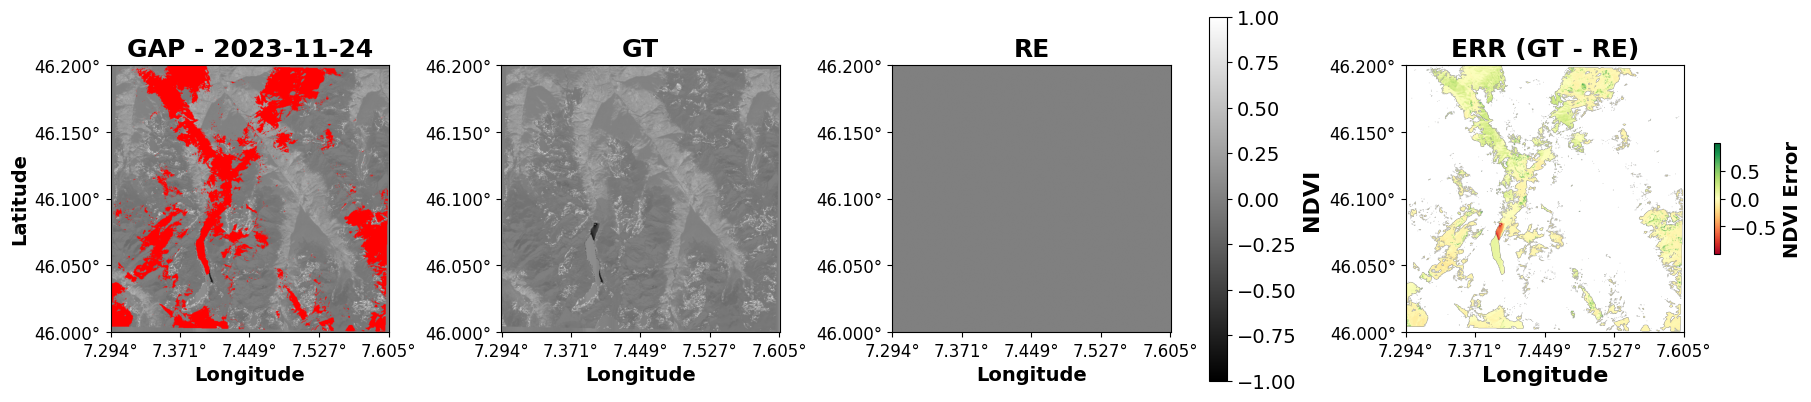

✅ Figure enregistrée : /content/drive/MyDrive/QS_herens/graph_herens_30105/qs_herens_2023-11-24.png


In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from pyproj import Transformer, CRS
import os
from glob import glob

# === Dossiers ===
hole_dir = '/content/drive/MyDrive/QS_herens/NDVI_herens_holes'
gt_dir = '/content/drive/MyDrive/QS_herens/NDVI_herens_full'
recon_dir = '/content/drive/MyDrive/QS_herens/QS_h_out'

# === Liste des fichiers ===
hole_files = sorted(glob(os.path.join(hole_dir, '*.tif')))
gt_files = sorted(glob(os.path.join(gt_dir, '*.tif')))
recon_files = sorted(glob(os.path.join(recon_dir, '*.tif')))   # nouveau format

# === Fonctions utilitaires ===
def read_tif_with_meta(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        meta = src.meta.copy()
    arr[arr == meta.get('nodata', -9999)] = np.nan
    return arr, meta

def resample_to_match(source_arr, source_meta, target_meta):
    dst_arr = np.empty((target_meta['height'], target_meta['width']), dtype=np.float32)
    reproject(
        source=source_arr,
        destination=dst_arr,
        src_transform=source_meta['transform'],
        src_crs=source_meta['crs'],
        dst_transform=target_meta['transform'],
        dst_crs=target_meta['crs'],
        resampling=Resampling.bilinear
    )
    return dst_arr

def add_coords_wgs84(ax, meta, show_y=True):
    transform = meta['transform']
    nrows, ncols = meta['height'], meta['width']

    x_idx = np.linspace(0, ncols - 1, 5, dtype=int)
    y_idx = np.linspace(0, nrows - 1, 5, dtype=int)
    x_pix = transform[2] + x_idx * transform[0]
    y_pix = transform[5] + y_idx * transform[4]

    raster_crs = CRS(meta['crs'])
    if raster_crs.to_epsg() != 4326:
        transformer = Transformer.from_crs(raster_crs, "EPSG:4326", always_xy=True)
        x_pix, y_pix = transformer.transform(x_pix, y_pix)

    ax.set_xticks(x_idx)
    ax.set_xticklabels([f'{x:.3f}°' for x in x_pix], rotation=0, fontsize=12)

    if show_y:
        ax.set_yticks(y_idx)
        ax.set_yticklabels([f'{y:.3f}°' for y in y_pix], fontsize=12)
    else:
        ax.set_yticks([])

# === Visualisation ===
for i in range(len(hole_files)):
    fname = os.path.basename(hole_files[i])
    date = fname.replace('NDVI_', '').replace('.tif', '')

    # Lecture
    hole, hole_meta = read_tif_with_meta(hole_files[i])
    gt, gt_meta = read_tif_with_meta(gt_files[i])
    recon, recon_meta = read_tif_with_meta(recon_files[i])  # nouveau nom ok

    # Alignement selon HOLE (tel que ton script actuel le fait)
    gt_resampled = resample_to_match(gt, gt_meta, hole_meta)
    recon_resampled = resample_to_match(recon, recon_meta, hole_meta)

    gap_mask = np.isnan(hole)

    err = np.full_like(hole, np.nan)
    valid_mask = gap_mask & ~np.isnan(gt_resampled) & ~np.isnan(recon_resampled)
    err[valid_mask] = gt_resampled[valid_mask] - recon_resampled[valid_mask]

    ndvi_cmap = cm.get_cmap("gray").copy()
    ndvi_cmap.set_bad(color="red")

    fig, axs = plt.subplots(1, 4, figsize=(18, 4), constrained_layout=True)
    axs = axs.flatten()

    im0 = axs[0].imshow(hole, cmap=ndvi_cmap, vmin=-1, vmax=1)
    axs[0].set_title(f"GAP - {date}", fontsize=18, fontweight="bold")
    axs[0].set_ylabel("Latitude", fontsize=14, fontweight="bold")
    axs[0].set_xlabel("Longitude", fontsize=14, fontweight="bold")
    add_coords_wgs84(axs[0], hole_meta, show_y=True)

    im1 = axs[1].imshow(gt_resampled, cmap=ndvi_cmap, vmin=-1, vmax=1)
    axs[1].set_title("GT", fontsize=18, fontweight="bold")
    axs[1].set_xlabel("Longitude", fontsize=14, fontweight="bold")
    add_coords_wgs84(axs[1], hole_meta)

    im2 = axs[2].imshow(recon_resampled, cmap=ndvi_cmap, vmin=-1, vmax=1)
    axs[2].set_title("RE", fontsize=18, fontweight="bold")
    axs[2].set_xlabel("Longitude", fontsize=14, fontweight="bold")
    add_coords_wgs84(axs[2], hole_meta)

    im3 = axs[3].imshow(err, cmap="RdYlGn")
    axs[3].set_title("ERR (GT - RE)", fontsize=18, fontweight="bold")
    axs[3].set_xlabel("Longitude", fontsize=16, fontweight="bold")
    add_coords_wgs84(axs[3], hole_meta)

    cbar_ndvi = fig.colorbar(im2, ax=axs[:3], orientation="vertical", fraction=0.5, pad=0.01)
    cbar_ndvi.set_label("NDVI", fontsize=16, fontweight="bold")
    for t in cbar_ndvi.ax.get_yticklabels():
        t.set_fontsize(14)

    cbar_err = fig.colorbar(im3, ax=axs[3], orientation="vertical", fraction=0.02, pad=0.01)
    cbar_err.set_label("NDVI Error", fontsize=14, fontweight="bold")
    for t in cbar_err.ax.get_yticklabels():
        t.set_fontsize(14)

    for ax in axs:
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)

    plt.show()

    save_dir = '/content/drive/MyDrive/QS_herens/graph_herens_30105'
    os.makedirs(save_dir, exist_ok=True)

    save_path = os.path.join(save_dir, f'qs_herens_{date}.png')
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"✅ Figure enregistrée : {save_path}")


In [7]:
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import reproject, Resampling
from sklearn.metrics import mean_squared_error, r2_score
import torch
import piq
from glob import glob

# === Dossiers ===
hole_dir = '/content/drive/MyDrive/QS_herens/NDVI_herens_holes'
gt_dir = '/content/drive/MyDrive/QS_herens/NDVI_herens_full'
recon_dir = '/content/drive/MyDrive/QS_herens/QS_h_out'

# === Liste des fichiers ===
hole_files = sorted(glob(os.path.join(hole_dir, '*.tif')))
gt_files = sorted(glob(os.path.join(gt_dir, '*.tif')))
recon_files = sorted(glob(os.path.join(recon_dir, '*.tif')))  # <-- changé ici

# === Fonctions utilitaires ===
def read_tif_with_meta(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        meta = src.meta.copy()
    arr[arr == meta.get('nodata', -9999)] = np.nan
    return arr, meta

def resample_to_match(source_arr, source_meta, target_meta):
    dst_arr = np.empty((target_meta['height'], target_meta['width']), dtype=np.float32)
    reproject(
        source=source_arr,
        destination=dst_arr,
        src_transform=source_meta['transform'],
        src_crs=source_meta['crs'],
        dst_transform=target_meta['transform'],
        dst_crs=target_meta['crs'],
        resampling=Resampling.bilinear
    )
    return dst_arr

# === Fonction métriques ===
def evaluate_metrics(gt_img, recon_img, gap_mask, image_name):
    valid_mask = gap_mask & ~np.isnan(gt_img) & ~np.isnan(recon_img)
    if np.sum(valid_mask) == 0:
        return pd.DataFrame([{
            'Image name': image_name,
            'RMSE': np.nan, 'R²': np.nan, 'MAE': np.nan,
            'MS-SSIM': np.nan, '% reconstructed pixels': 0.0
        }])

    y_true = gt_img[valid_mask]
    y_pred = recon_img[valid_mask]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred) if np.var(y_true) > 1e-8 else np.nan
    mae = np.mean(np.abs(y_true - y_pred))

    # Normalisation pour MS-SSIM
    min_val = np.min([y_true.min(), y_pred.min()])
    max_val = np.max([y_true.max(), y_pred.max()])
    if max_val - min_val < 1e-8:
        ms_ssim_score = np.nan
    else:
        gt_norm = (gt_img - min_val) / (max_val - min_val)
        recon_norm = (recon_img - min_val) / (max_val - min_val)
        gt_norm[~valid_mask] = 0.0
        recon_norm[~valid_mask] = 0.0

        gt_tensor = torch.from_numpy(gt_norm).unsqueeze(0).unsqueeze(0).float()
        recon_tensor = torch.from_numpy(recon_norm).unsqueeze(0).unsqueeze(0).float()

        ms_ssim_score = piq.multi_scale_ssim(gt_tensor, recon_tensor, data_range=1., reduction='none').item()

    coverage = (np.sum(valid_mask) / np.sum(gap_mask)) * 100 if np.sum(gap_mask) > 0 else 0.0

    return pd.DataFrame([{
        'Image name': image_name,
        'RMSE': rmse,
        'R²': r2,
        'MAE': mae,
        'MS-SSIM': ms_ssim_score,
        '% reconstructed pixels': coverage
    }])

# === Calcul des métriques ===
all_results = []

for hole_path in hole_files:

    fname = os.path.basename(hole_path)
    date_str = fname.replace('NDVI_', '').replace('.tif', '')

    # Lecture hole
    hole_img, hole_meta = read_tif_with_meta(hole_path)

    # Lecture GT (matching date)
    gt_path = [f for f in gt_files if date_str in os.path.basename(f)][0]
    gt_img, gt_meta = read_tif_with_meta(gt_path)
    gt_resampled = resample_to_match(gt_img, gt_meta, hole_meta)

    # Lecture reconstruction (matching date = nouveau nom)
    recon_path = [f for f in recon_files if date_str in os.path.basename(f)][0]
    recon_img, recon_meta = read_tif_with_meta(recon_path)
    recon_resampled = resample_to_match(recon_img, recon_meta, hole_meta)

    # Mask trous
    gap_mask = np.isnan(hole_img)

    # Calcul metrics
    df = evaluate_metrics(gt_resampled, recon_resampled, gap_mask, fname)
    all_results.append(df)

# Table finale
metrics_table = pd.concat(all_results, ignore_index=True)
metrics_table

,Image name,RMSE,R²,MAE,MS-SSIM,% reconstructed pixels
0,NDVI_2013-04-18.tif,0.069540,0.580560,0.037593,0.965178,100.0
1,NDVI_2013-09-25.tif,0.056605,0.854219,0.032084,0.993286,100.0
2,NDVI_2017-04-29.tif,0.063648,0.660319,0.031107,0.988516,100.0
3,NDVI_2018-10-09.tif,0.049313,0.854024,0.028613,0.985532,100.0
4,NDVI_2022-04-27.tif,0.054771,0.738444,0.030047,0.981927,100.0
5,NDVI_2023-11-24.tif,0.142482,-0.034386,0.091304,0.981342,100.0


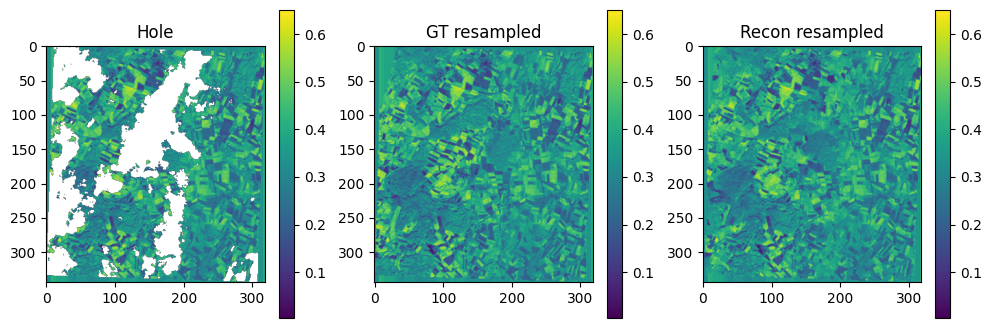

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Hole"); plt.imshow(hole_img); plt.colorbar()
plt.subplot(1,3,2); plt.title("GT resampled"); plt.imshow(gt_resampled); plt.colorbar()
plt.subplot(1,3,3); plt.title("Recon resampled"); plt.imshow(recon_resampled); plt.colorbar()
plt.show()
